In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

df = pd.read_pickle('treino.pkl.gz')

In [2]:
# função 'chamada' por 'proba_box'    
def discretize_proba(x, thresh):
    for n in range(len(thresh)):
        if x == thresh[n]:
            return n + 1
        
# discretiza feature quantitativa, utilizando árvores de decisão, armazena novas categorias em outra feature, 
# plota box plot de acordo com  taxa de default em cada nova categoria, gerada na discretização

# apesar de criar nova feature no dataframe passado, suponho que não haja problema, por exemplo, rodar
# duas vezes em sequência, com diferentes n(max_depth), uma vez que, as novas features são criadas com base
# na feature de nome 'series_name', que permanece inalterada, o que acontece, caso esta função seja 'chamada'
# diversas vezes é que a nova feature é constantemente redefinida
def proba_box(dataframe, series_name, target, max_depth, random_state):
    
    disc = DecisionTreeClassifier(max_depth = max_depth, random_state = random_state)
    disc.fit(dataframe[[series_name]], dataframe[[target]])
    dataframe[series_name + '_proba'] = disc.predict_proba(dataframe[[series_name]])[:, 1] 
    
    thresh = dataframe[series_name + '_proba'].unique().tolist()
    thresh.sort()

    dataframe[series_name + '_proba'] = dataframe[series_name + '_proba'].apply(lambda x: 
                                                                                discretize_proba(x, thresh)) 

    plt.style.use('default')
    plt.rcParams['figure.figsize'] = (11, 5)
    sns.boxplot(dataframe[series_name + '_proba'], dataframe[series_name])
    plt.show()
    
# visualizar árvore de decisão (permite analisar como foi feita a discretização)
def tree_thresholds(dataframe, series_name, target, max_depth, random_state):
    mdl = DecisionTreeClassifier(random_state = random_state, max_depth = max_depth)
    mdl.fit(dataframe[[series_name]], dataframe[[target]])
    plt.style.use('default')
    fig = plt.figure(figsize = (12, 5))
    _ = tree.plot_tree(mdl)
    plt.show()

# roda funções tree_thresholds e proba_box em conjunto, para quantas camadas de árvore forem solicitadas
def tree_box_plot(dataframe, series_name, target, iterations, random_state):
    for i in iterations:
        tree_thresholds(dataframe, series_name, target, i, random_state)
        proba_box(dataframe, series_name, target, i, random_state)
        
def target_prop_bin(dataframe, series_name, target):
    
    plot_data = []
    for i in dataframe[series_name].unique():
        data = dataframe.loc[dataframe[series_name] == i, target].value_counts(1)
        if len(data) == 2:
            plot_data.append([str(i), data.iloc[1]])
        if len(data) < 2:
            plot_data.append([str(i), data.iloc[0]])
            

    plot_data.sort()
    for i in plot_data:
        plt.bar(i[0], i[1], color = 'turquoise')
        
    plt.xticks(range(len(plot_data)), [i[0] for i in plot_data])
    plt.xticks(rotation = 45)
    plt.yticks([])
    plt.show() 
    
# teste de independência entre variáveis categóricas    
def quali_var_indep_hyp_test(dataframe, series_name, target, alpha):
    
    stat, pval, dof, exp = chi2_contingency(pd.crosstab(dataframe[series_name], dataframe[target]))
    crit = chi2.ppf(q = (1 - alpha), df = dof)
    
    if stat >= crit:
        cramer = np.sqrt( ( stat ) / sum(sum(exp)) * (min(exp.shape) - 1) )
    else:
        cramer = None
    
    return stat, crit, cramer

# tranformar feature 'nascimento' em 'idade'
def year_to_age(x):

    if x == '00':
        return 20
    
    else:
        return (100 - int(x)) + 20

# transformar formato e unidade das features 'tem_med_emp' e 'tem_pri_emp'    
def time_unit_unification(x):
    
    sub1 = x.split(' ')[0]
    sub2 = x.split(' ')[1]
    return (int(sub1.strip('yrs')) * 12) + int(sub2.strip('mon'))

plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (16, 8)

In [4]:
# seleção preliminar de features:
# o critério desta foi: lógica / explicabilidade, as features eliminadas são consideradas como não relacionadas
# à probabilidade de 'deafult' ou não

sub1 = ['id_pessoa', 'valor_emprestimo', 'custo_ativo', 'emprestimo_custo', 'nascimento', 'emprego', 'score', 
        'score_desc']
sub2 = ['tem_med_emp', 'tem_pri_emp']
sub4 = ['pri_qtd_tot_emp', 'pri_qtd_tot_emp_atv', 'pri_qtd_tot_def', 'pri_emp_abt', 'pri_emp_san','pri_emp_tom']
sub5 = ['sec_qtd_tot_emp', 'sec_qtd_tot_emp_atv', 'sec_qtd_tot_def', 'sec_emp_abt', 'sec_emp_san','sec_emp_tom']

# sub1_dropd = ['agencia', 'revendedora', 'montadora', 'Current_pincode_ID', 'data_contrato', 'estado', 
#               'funcionario']
# sub2_dropd = ['par_pri_emp', 'par_seg_emp', 'nov_emp_6m', 'def_emp_6m', 'qtd_sol_emp']
# sub3 = ['flag_telefone', 'flag_aadhar', 'flag_pan', 'flag_eleitor', 'flag_cmotorista', 'flag_passaporte']


# --------------------
# darei início à análise com as features: 'valor_emprestimo', 'custo_ativo', 'emprestimo_custo'
# suponho que estas possuam correlção entre si, sendo assim, cogito resumi-las em apenas uma variável, 
# a presença de diversas features contendo informações sobre um mesmo aspecto acaba por atribuir um peso maior
# ao mesmo, além disso, não traz informações úteis e nos sujeitamos à maldição da dimensionalidade 

# ao consultar a metadata:
# valor_emprestimo -> Valor total emprestado pela financeira
# custo_ativo -> Custo do ativo(veículo)
# emprestimo_custo -> Razão entre valor emprestado e valor do ativo(veículo)

# já 'por definição', conclui-se que emprestimo custo estará altamente correlacionada a uma combinação entre
# 'valor_emprestimo' e 'custo_ativo', que por sua vez, também possuem correlação entre si

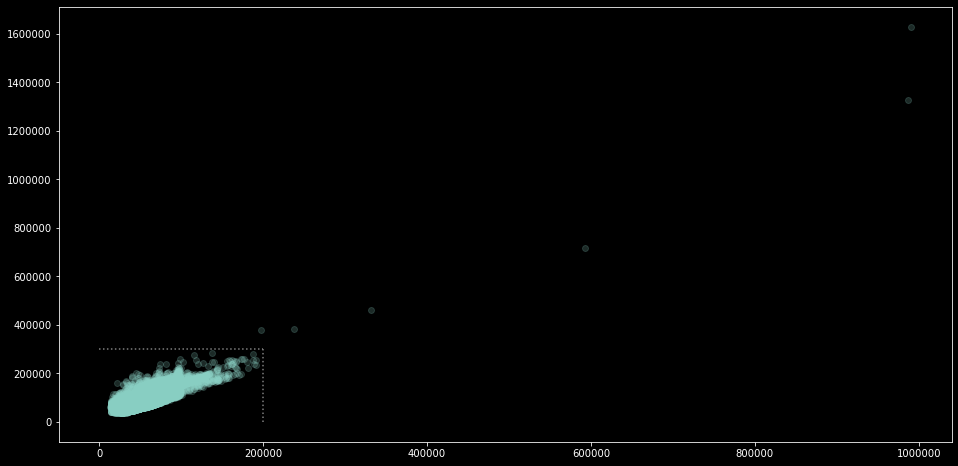

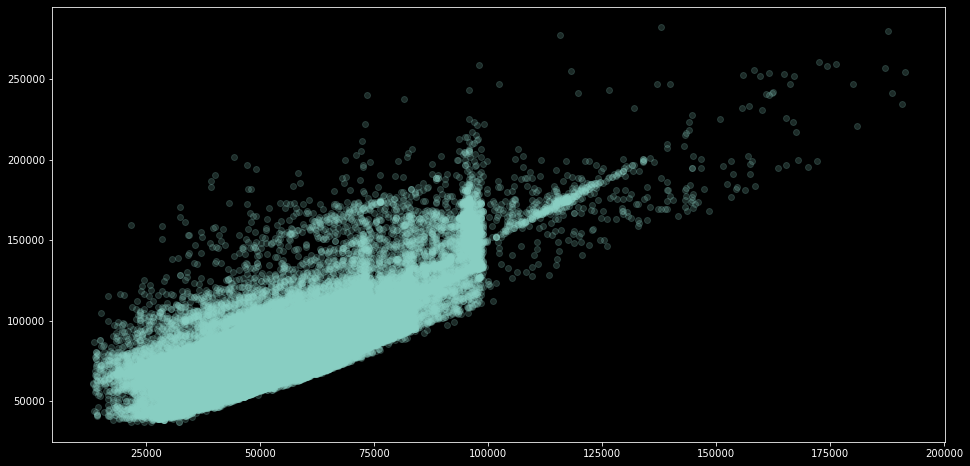

In [5]:
# ao observar o gráfico de dispersão entre as variáveis, percebemos a necessidade de eliminar outliers
# (ao menos para a visualização do gráfico de dispersão)

plt.scatter(df['valor_emprestimo'], df['custo_ativo'], alpha = 0.2)
plt.plot([0, 200000], [300000, 300000], color = 'grey', ls = ':')
plt.plot([200000, 200000], [0, 300000], color = 'grey', ls = ':')
plt.show()

aux = df.copy()
aux = aux.loc[(aux['valor_emprestimo'] <= 200000) & (aux['custo_ativo'] <= 300000)]
plt.scatter(aux['valor_emprestimo'], aux['custo_ativo'], alpha = 0.2)
plt.show()

In [7]:
# precisa rodar duas vezes, r = 0.7387544522220792 (sem outliers), r = 0.756227463624271 (com outliers)
print('r:', pearsonr(df['valor_emprestimo'], df['custo_ativo']))
print('r:', pearsonr(aux['valor_emprestimo'], aux['custo_ativo']))

# eliminar outliers nos ajudou a visualizar melhor a correlação, no gráfico de dispersão, mas continuo
# o projeto sem eliminá-los

r: (0.756227463624271, 0.0)
r: (0.7387544522220792, 0.0)


In [8]:
# combinando 'valor_emprestimo' e 'custo_ativo'

# faz sentido fazer isso ? já que possuem correlação significativa, combino-as desta maneira
df['dif_val_custo'] = df['custo_ativo'] - df['valor_emprestimo'] 

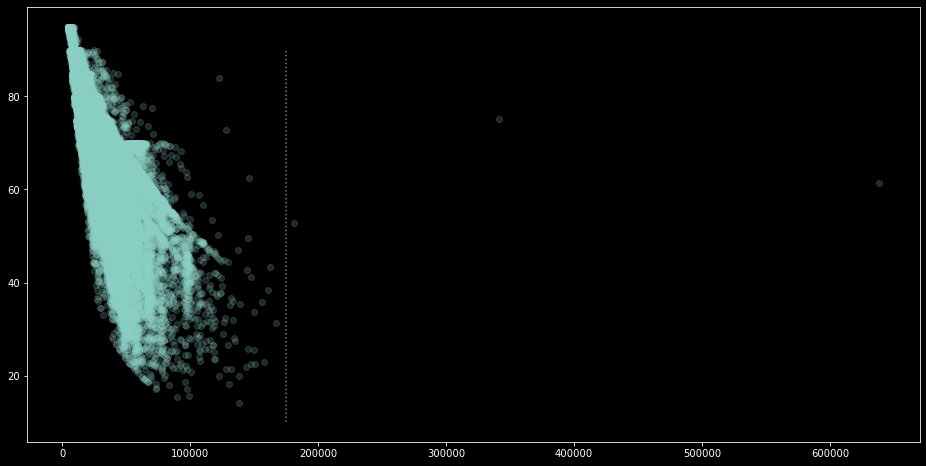

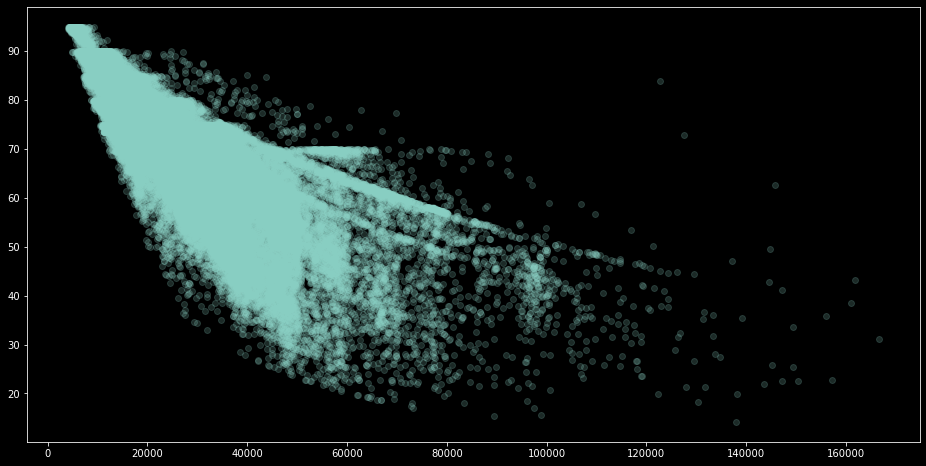

In [9]:
# agora nos restam as features 'dif_val_custo' e 'emprestimo_custo', que plotadas em um gráfico de dispersão, 

plt.scatter(df['dif_val_custo'], df['emprestimo_custo'], alpha = 0.2)
plt.plot([175000, 175000], [10, 90], ls = ':', color = 'grey')
plt.show()

# novamente, outliers dificultam a visualização do plot
# estudo o cenário onde eliminamos os três pontos do lado direito da linha pontilhada cinza
aux = df.copy()
aux = aux.loc[aux['dif_val_custo'] <= 175000]
plt.scatter(aux['dif_val_custo'], aux['emprestimo_custo'], alpha = 0.2)
plt.show()

In [11]:
# precisa rodar duas vezes r = -0.8429519408328675(com outliers), r = -0.8499209407779268 (sem outliers)
print('r:', pearsonr(df['dif_val_custo'], df['emprestimo_custo']))
print('r:', pearsonr(aux['dif_val_custo'], aux['emprestimo_custo']))

# eliminar outliers nos ajudou a visualizar melhor a correlação, no gráfico de dispersão, mas continuo
# o projeto sem eliminá-los

# não sei como cominar estas duas features, posto que uma consiste em uma proporção, e outra em um valor
# 'inteiro', então, avaliarei a importância de uma contra a outra, discrertizando-as com árvores de decisão, 
# em seguida, plotando as taxas de 'default' para cada uma e julgando qual ordena o mesmo com maior eficácia

r: (-0.8429519408328675, 0.0)
r: (-0.8499209407779268, 0.0)


In [13]:
# testo 16, 8 e 4 bins, mas o único número que traz resultados interessantes é 4 bins

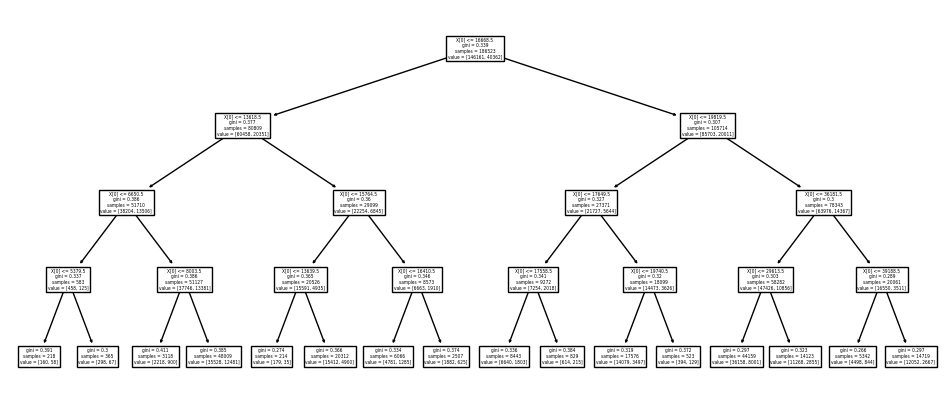

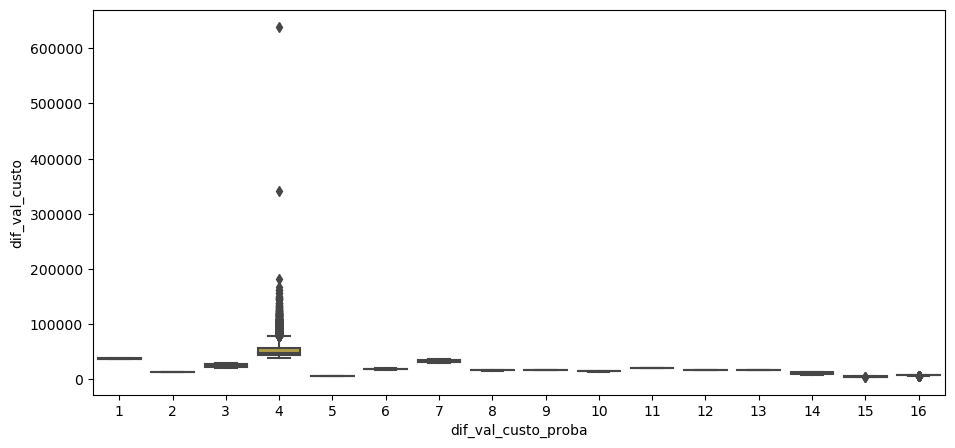

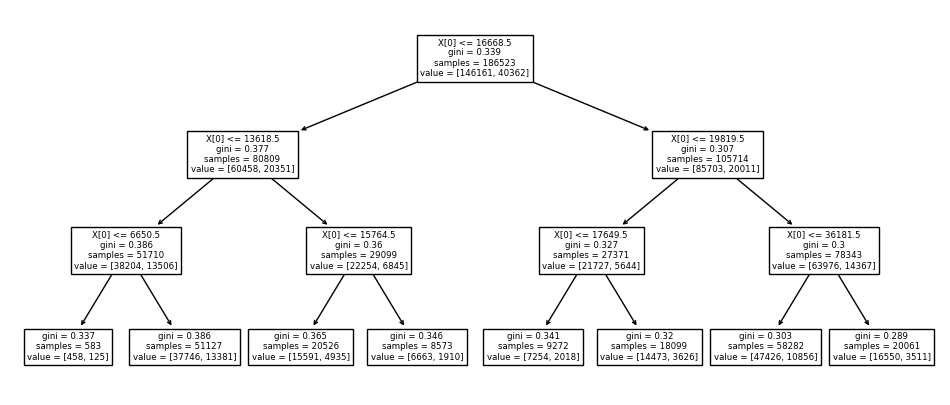

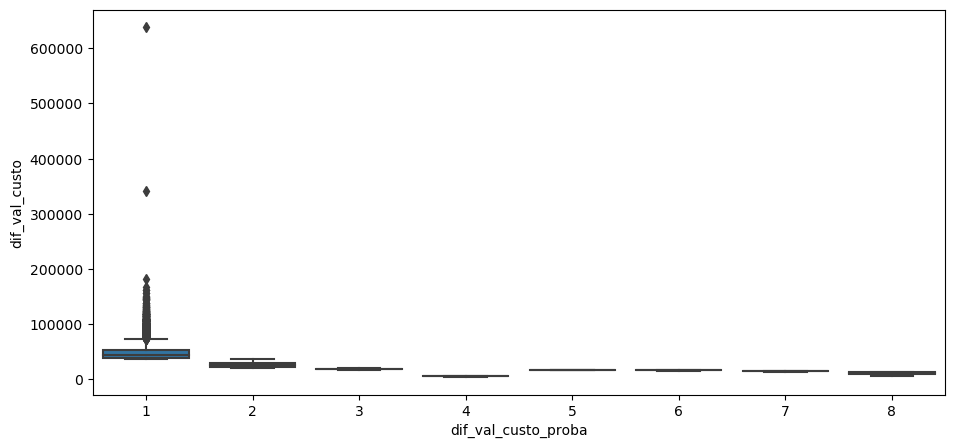

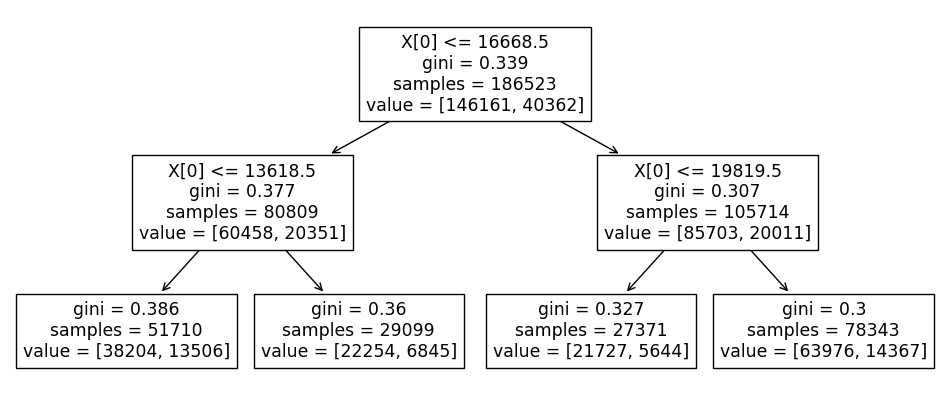

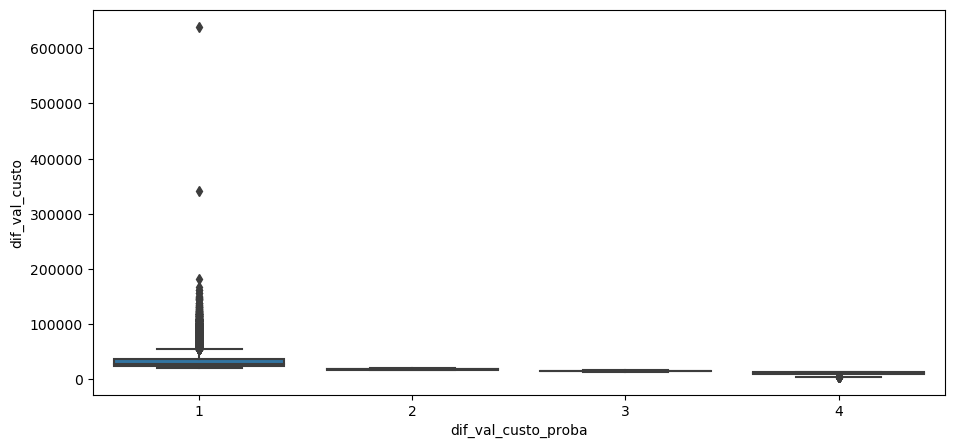

In [14]:
tree_box_plot(df, 'dif_val_custo', 'default', [4, 3, 2], 42)

In [15]:
# conforme o eixo x cresce, maior a probabilidade de 'default', as ordenadas contém a variável quantitativa

# na próxima célula, realizo o mesmo processo em 'emprestimo_custo'

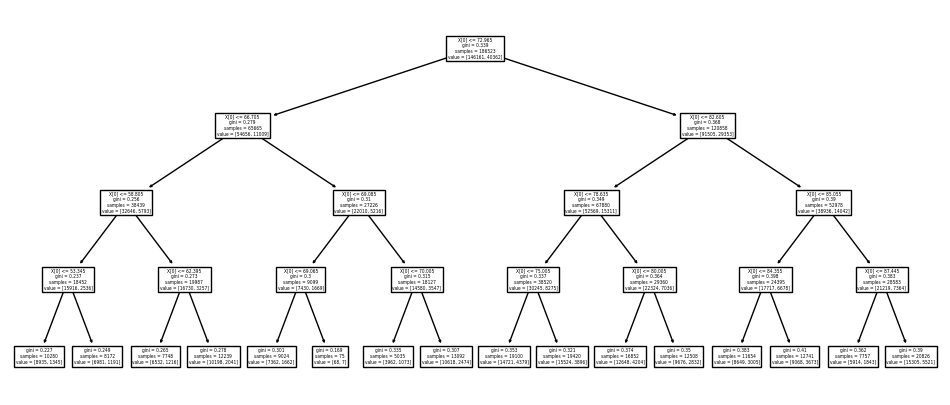

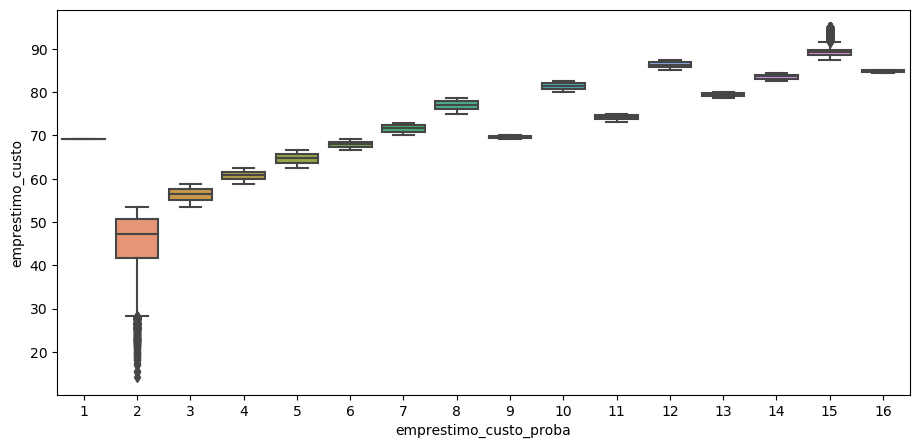

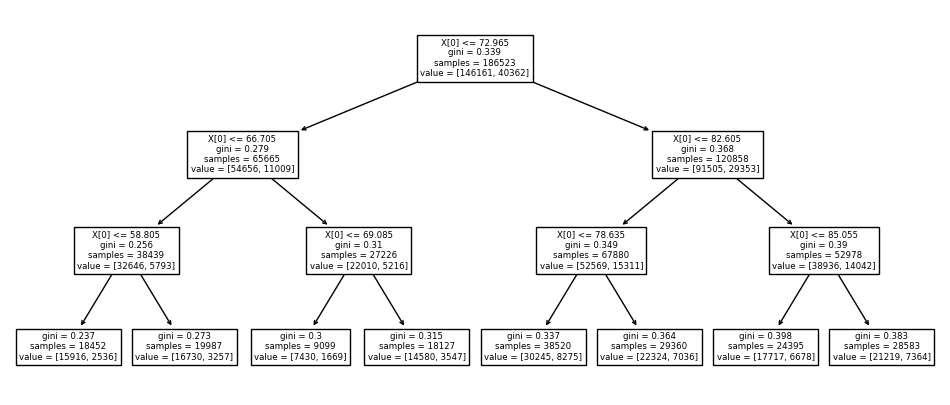

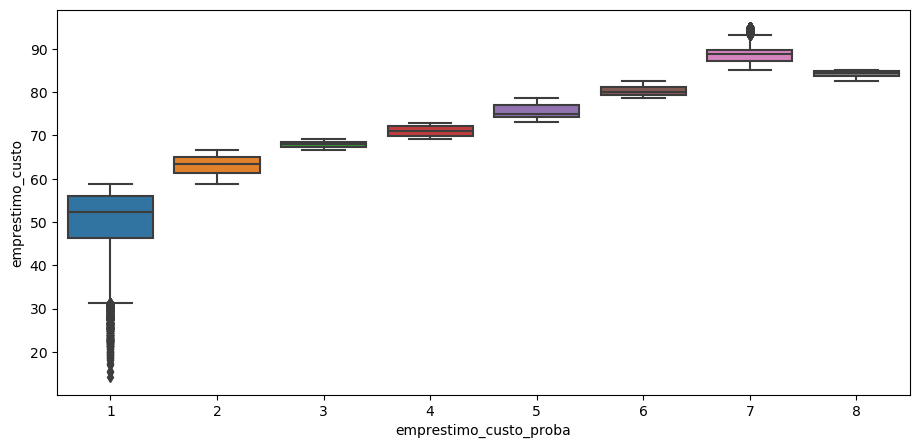

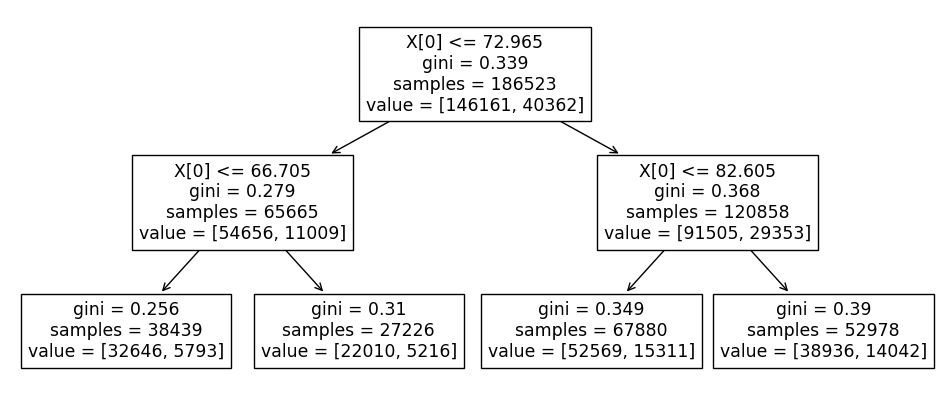

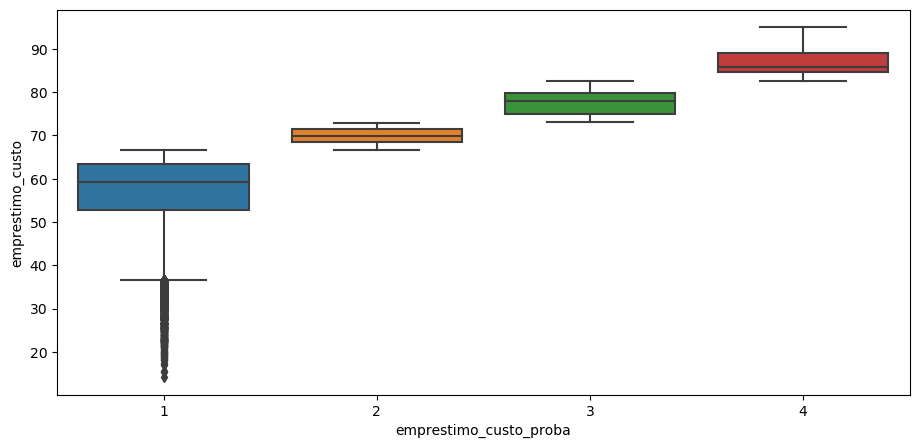

In [16]:
tree_box_plot(df, 'emprestimo_custo', 'default', [4, 3, 2], 42)

In [17]:
# no caso de 'emprestimo_custo', percebe-se que existe uma correlação significativa com a probabilidade de 
# 'default'

# conclusão da análise de 'valor_emprestimo', 'custo_ativo', 'emprestimo_custo':
# talvez possamos usar a variável 'emprestimo_custo'

In [18]:
# em seguida, faço a análise e transformação de 'nascimento'

# possíveis anos de nascimento:
# suponho que todos sejam '19--', com exceção de '1900', neste caso, considero que o ano seja '2000'
df['nascimento'].str[6:].unique()

array(['76', '97', '83', '94', '92', '80', '79', '95', '96', '72', '73',
       '71', '88', '84', '61', '70', '75', '85', '69', '77', '67', '82',
       '74', '89', '63', '64', '87', '65', '91', '81', '90', '78', '86',
       '93', '99', '68', '62', '98', '55', '58', '59', '66', '00', '60',
       '56', '54', '57', '49'], dtype=object)

In [19]:
df['nascimento'] = df['nascimento'].str[6:].apply(lambda x: year_to_age(x))
df = df.rename(columns = {'nascimento': 'idade'})

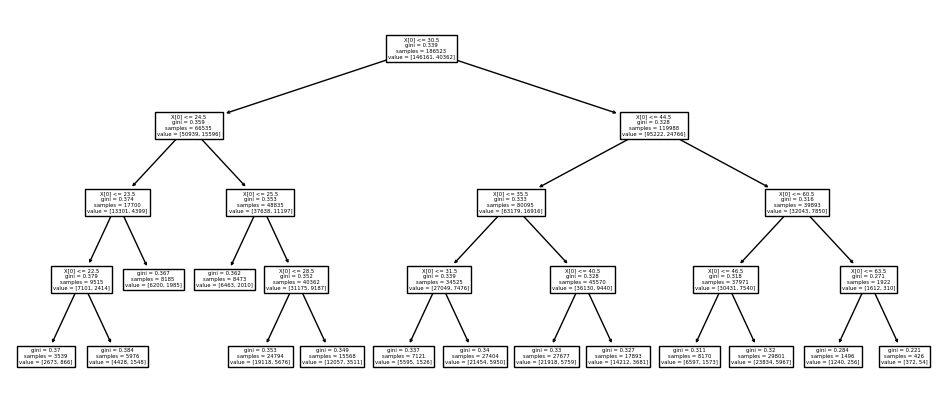

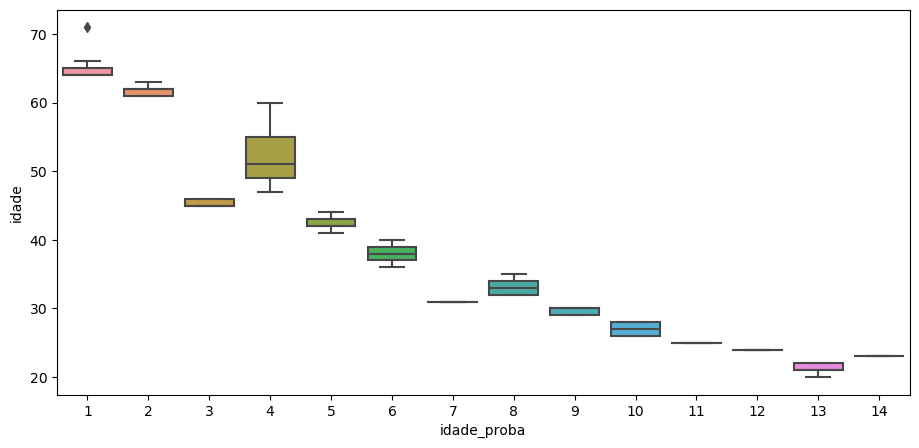

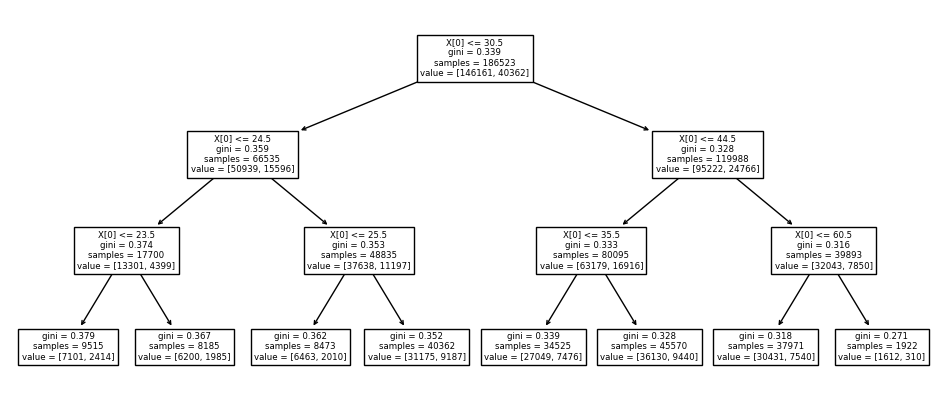

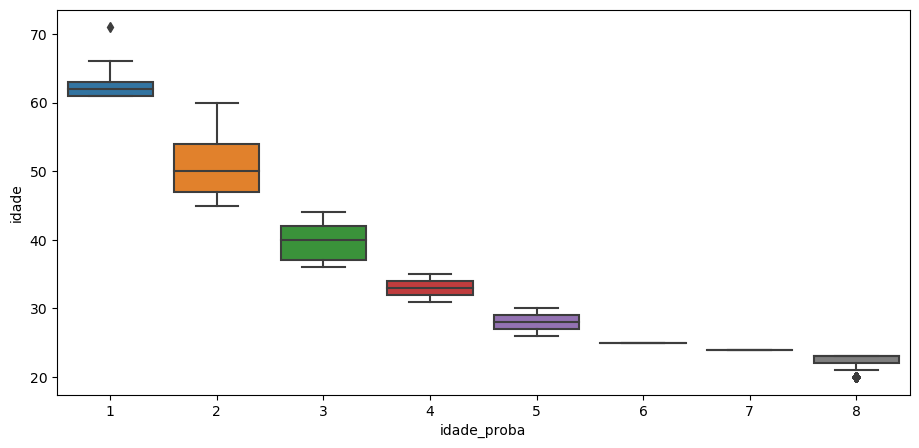

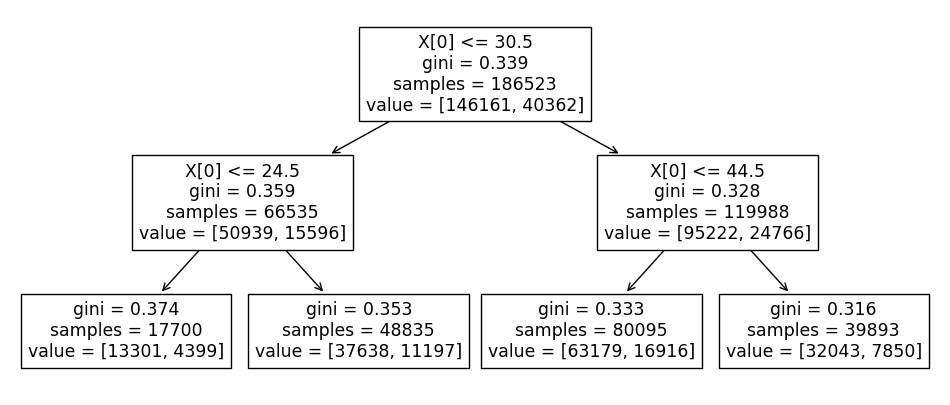

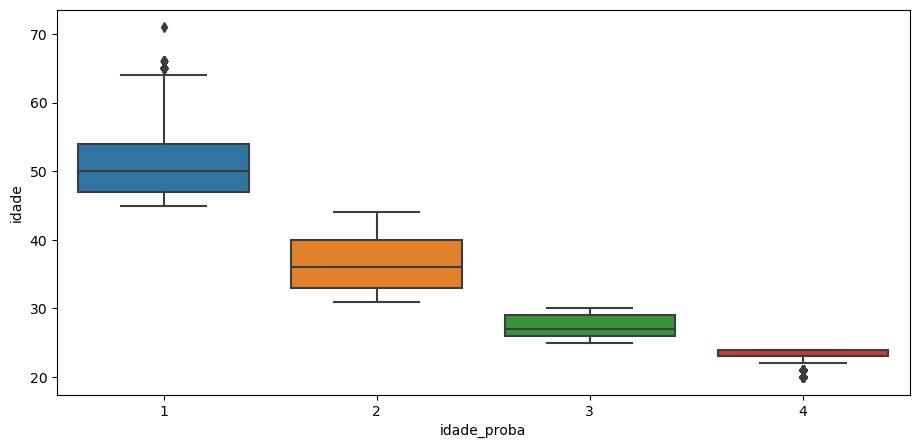

In [20]:
tree_box_plot(df, 'idade', 'default', [4, 3, 2], 42)

In [21]:
# conclusão da análise de idade:
# por mais que exista a possibilidade de gerar controvérsias, a variável idade ordena o 'default' de forma 
# consistente

In [22]:
# em seguida, faço a análise da variável emprego

print(df['emprego'].isnull().value_counts())

df['emprego'].unique()

# será necessário imputar alguns valores

False    180376
True       6147
Name: emprego, dtype: int64


array(['Salaried', 'Self employed', nan], dtype=object)

In [23]:
imp = SimpleImputer(strategy = 'constant', fill_value = 'Unknown')
df['emprego'] = imp.fit_transform(df[['emprego']])
df['emprego'] = df['emprego'].str.replace(' ', '_')

In [24]:
# como se trata de uma variável qualitativa não ordinal, repetirei o processo das variáveis anteriores
# em vez disso, opto por realizar teste qui-quadrado, caso este acuse dependência, é realizado cramer V, 
# mensurando a força da mesma

stat, crit, cramer = quali_var_indep_hyp_test(df, 'emprego', 'default', 0.01)
print(round(stat, 2))
print(round(crit, 2))

145.54
9.21


In [25]:
# Com uma estatística qui-quadrada de 145.41, e um valor crítico de 9.21, falhamos em rejeitar a hipótese nula
# de independência, todavia, para quantificarmos a associação entre 'emprego' e 'default', consultamos
# Cramér's V, assim, sabemos se vale a pena manter esta variável no modelo
round(cramer, 3)

0.028

In [26]:
# conclusão da análise de emprego:
# associação insignificante

In [27]:
# em seguida, análise de 'score' e 'score_desc'

# suponho que seria seguro supor que estas variáveis trazem informações redundantes, entretanto, segue a
# análise destas, a fim de garantir que não perderemos informação, ao eliminar uma delas

In [28]:
df['score_desc'].value_counts(1)

No Bureau History Available                                0.502340
C-Very Low Risk                                            0.068828
A-Very Low Risk                                            0.060464
D-Very Low Risk                                            0.048750
B-Very Low Risk                                            0.039309
M-Very High Risk                                           0.037872
F-Low Risk                                                 0.036709
K-High Risk                                                0.035202
H-Medium Risk                                              0.029214
E-Low Risk                                                 0.024812
I-Medium Risk                                              0.023338
G-Low Risk                                                 0.017161
J-High Risk                                                0.016111
Not Scored: Sufficient History Not Available               0.016084
Not Scored: Not Enough Info available on the cus

In [29]:
# em um primeiro momento, de forma grosseira, considero a possibilidade de dividir os possíveis valores de 
# 'score_desc' entre possuindo a palavra 'Risk' ou se iniciar com 'No'

In [30]:
df.loc[df['score_desc'].str.contains('No'), 'score_desc'].unique().tolist()

['No Bureau History Available',
 'Not Scored: Only a Guarantor',
 'Not Scored: No Updates available in last 36 months',
 'Not Scored: No Activity seen on the customer (Inactive)',
 'Not Scored: Sufficient History Not Available',
 'Not Scored: Not Enough Info available on the customer',
 'Not Scored: More than 50 active Accounts found']

In [31]:
df.loc[(df['score_desc'].str.contains('Risk')) | (df['score_desc'].str.contains('Risk')), 
       'score_desc'].unique().tolist()

['F-Low Risk',
 'A-Very Low Risk',
 'C-Very Low Risk',
 'H-Medium Risk',
 'M-Very High Risk',
 'K-High Risk',
 'B-Very Low Risk',
 'I-Medium Risk',
 'D-Very Low Risk',
 'E-Low Risk',
 'J-High Risk',
 'G-Low Risk',
 'L-Very High Risk']

In [32]:
# à partir deste ponto, considero dois tipos de 'score_desc', os que contém 'Risk' e os que contém 'No'

valor máximo: 18


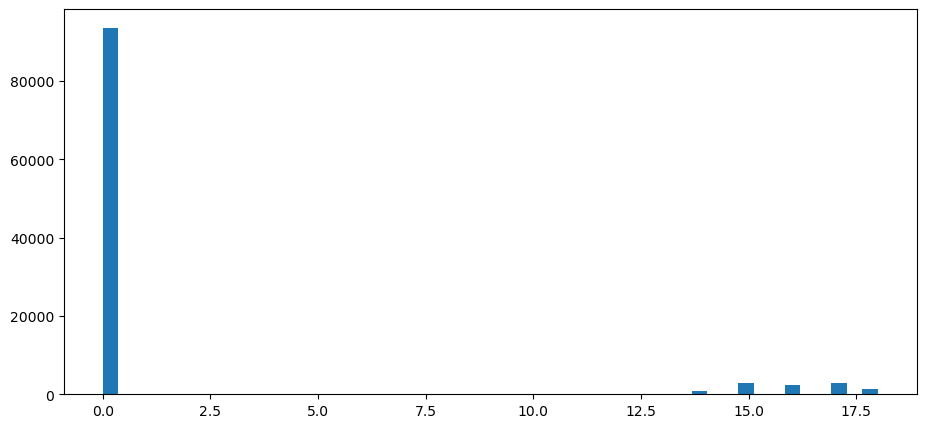

In [33]:
# como se comporta o 'score', em dados que possuem 'No' em 'score_desc' ?

# como é o score de dados nestes grupos ?
no_score = df.loc[df['score_desc'].str.contains('No'), 'score_desc'].unique().tolist()
no_score_score_series = df.loc[df['score_desc'].isin(no_score), 'score']
print('valor máximo:', no_score_score_series.max())
plt.hist(no_score_score_series, bins = 50)
plt.show()

In [34]:
# dados que possuem 'No' em seus 'score_desc' consistem principalmente em zeros, chegando a, no máximo, 18, 
# a princípio, não farei a discretização dos dados decidindo os limiares por conta própria, mas consigo 
# imaginar que poderíamos alocar todos os dados contendo 'No' em 'score_desc' sob a mesma categoria

In [35]:
# aprofundando análise dos valores de 'score_desc' que possuem 'Risk' ou 'risk'

print(df.loc[df['score_desc'].str.contains('Very Low'), 'score_desc'].unique())
print(df.loc[(df['score_desc'].str.contains('Low')) &
     (df['score_desc'].str.contains('Very') == False), 'score_desc'].unique())
print(df.loc[df['score_desc'].str.contains('Medium'), 'score_desc'].unique())
print(df.loc[(df['score_desc'].str.contains('High')) &
             (df['score_desc'].str.contains('Very') == False), 'score_desc'].unique())
print(df.loc[df['score_desc'].str.contains('Very High'), 'score_desc'].unique())

['A-Very Low Risk' 'C-Very Low Risk' 'B-Very Low Risk' 'D-Very Low Risk']
['F-Low Risk' 'E-Low Risk' 'G-Low Risk']
['H-Medium Risk' 'I-Medium Risk']
['K-High Risk' 'J-High Risk']
['M-Very High Risk' 'L-Very High Risk']


In [36]:
# o que querem dizer as letras?
# r:são subgrupos de cada tipo de risco, o risco aumenta conforme se percorre o alfabeto

# Very Low Risk (A, B, C, D)
# Low Risk (E, F, G)
# Medium Risk (H, I)
# High Risk (J, K)
# Very High Risk (L, M)

In [37]:
# como se comporta o 'score', para cada 'score_desc'
# dividir dados pela letra presente no 'score_desc'

df_risk_letter = df.copy()
df_risk_letter = df_risk_letter.loc[(df_risk_letter['score_desc'].str.contains('Risk')) |
                                    (df_risk_letter['score_desc'].str.contains('risk'))]
df_risk_letter['risk_letter'] = df_risk_letter['score_desc'].str[0]
df_risk_letter[['risk_letter', 'score']].groupby('risk_letter').mean()

,score
risk_letter,
A,827.646657
B,774.158211
C,741.895311
D,715.966128
E,691.516206
F,666.132175
G,640.968760
H,617.100385
I,586.856651


In [38]:
# dividir dados pelo valor presente no 'score_desc', desconsiderando a letra

df_risk_word = df.copy()
df_risk_word = df_risk_word.loc[(df_risk_word['score_desc'].str.contains('Risk')) |
                 (df_risk_word['score_desc'].str.contains('risk'))]
df_risk_word['risk_word'] = df_risk_word['score_desc'].str[2:]
df_risk_word[['risk_word', 'score']].groupby('risk_word').mean().sort_values('score')

,score
risk_word,
Very High Risk,303.005018
High Risk,474.778707
Medium Risk,603.669353
Low Risk,668.648474
Very Low Risk,765.769443


In [39]:
# com estas informações, concluo que não há necessidade de manter ambas variáveis('score' e 'score_desc')

# opto por manter 'score'

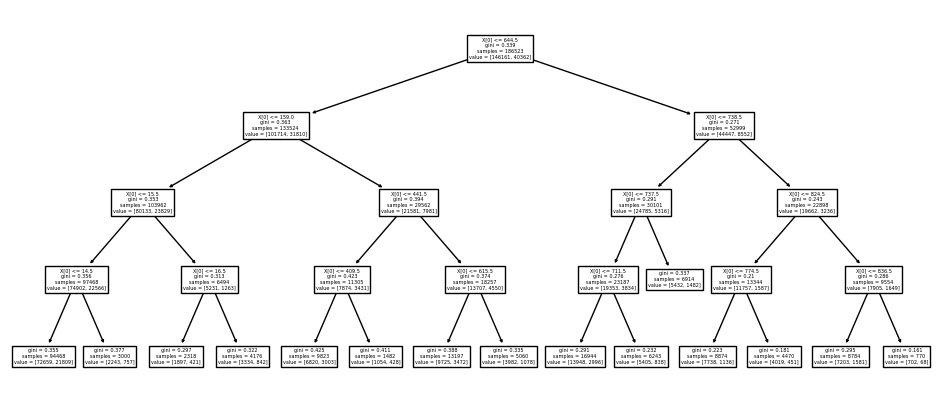

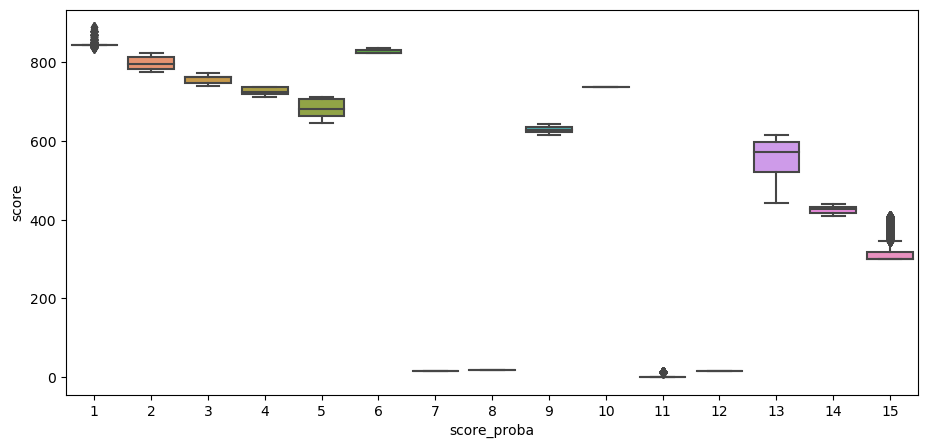

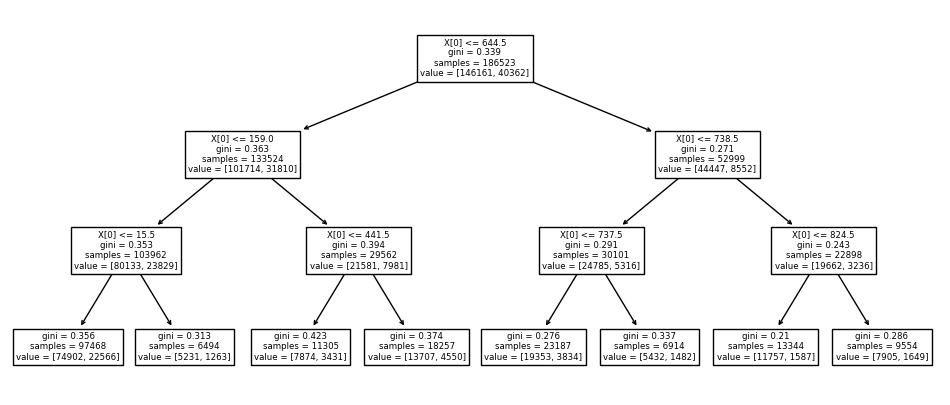

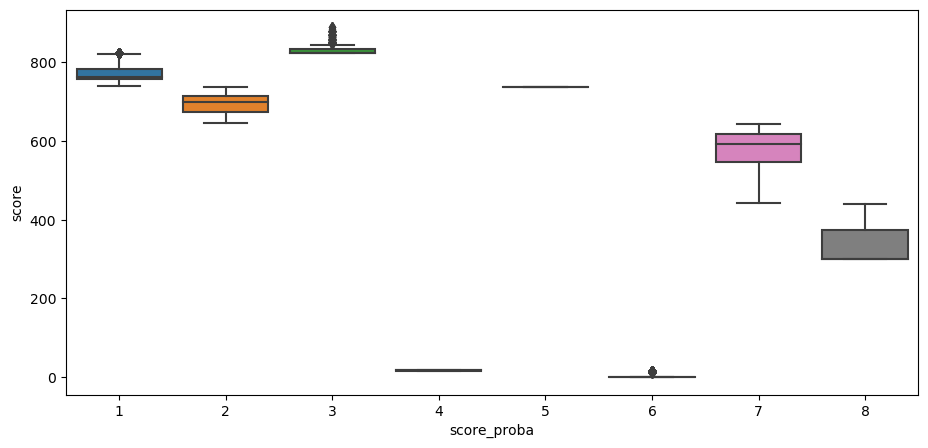

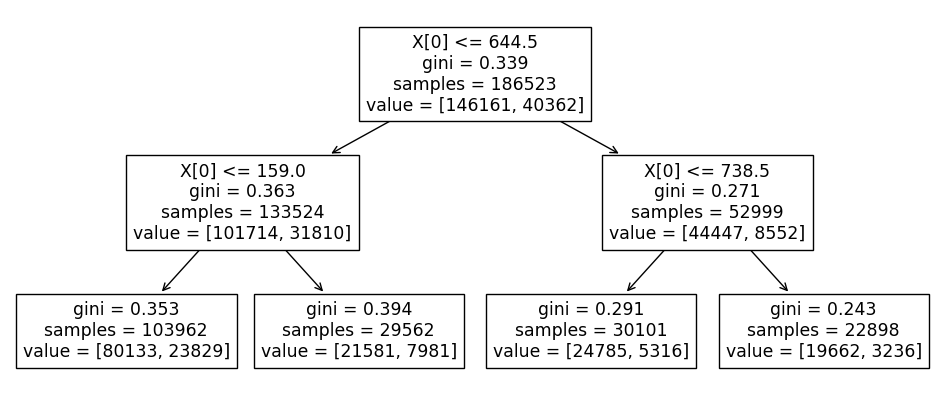

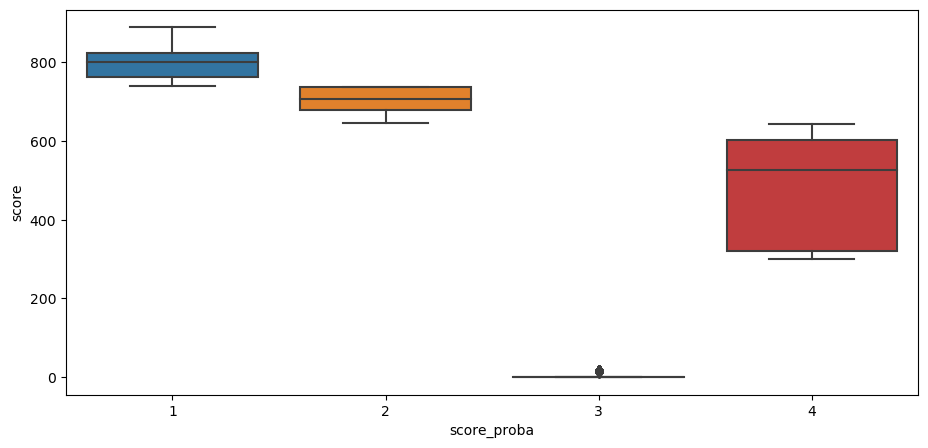

In [40]:
# prosseguindo com a análise de 'score'
tree_box_plot(df, 'score', 'default', [4, 3, 2], 42)

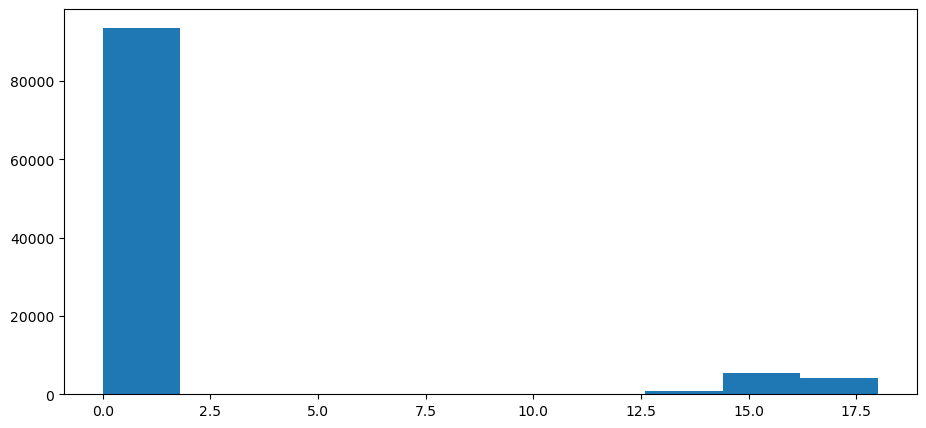

In [41]:
# resultado curioso, a expectativa era de que esta variável trouxesse muita informação sobre o alvo
# o que aconteceu em 3?
plt.hist(df.loc[df['score_proba'] == 3, 'score'])
plt.show()

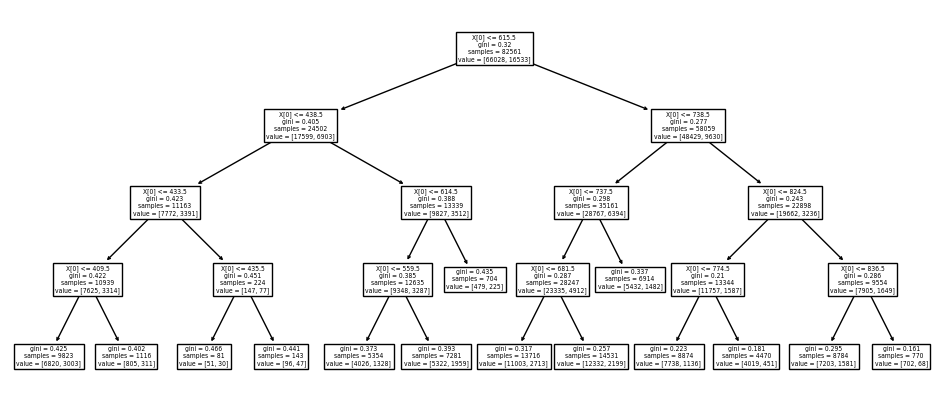

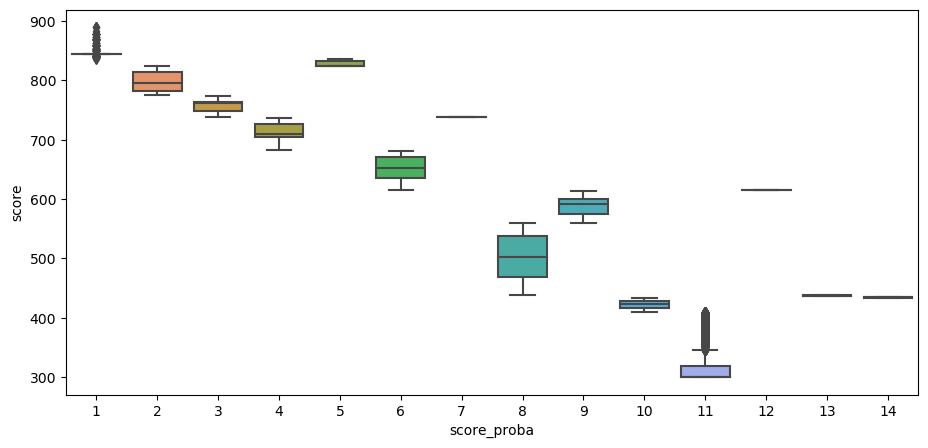

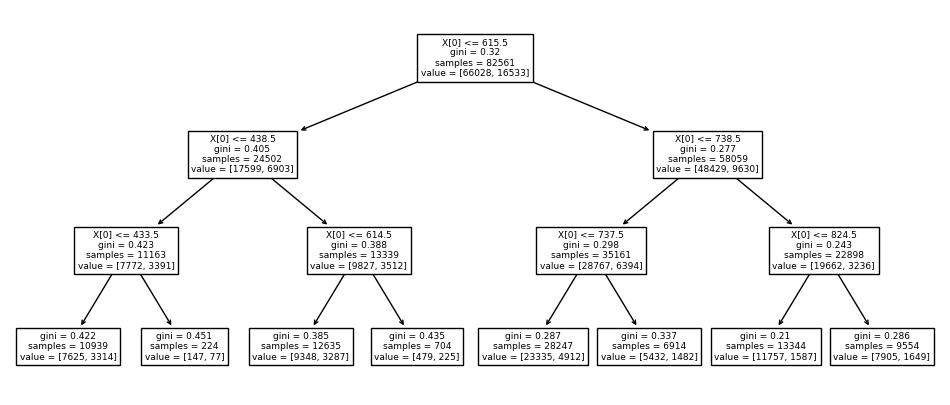

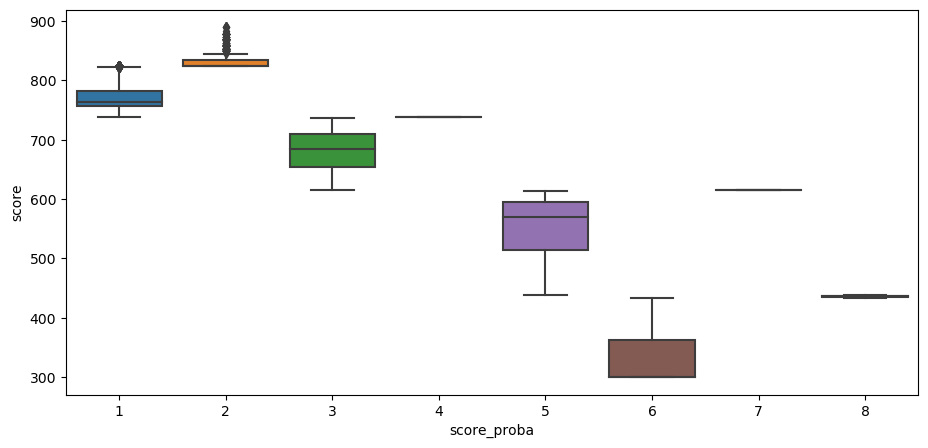

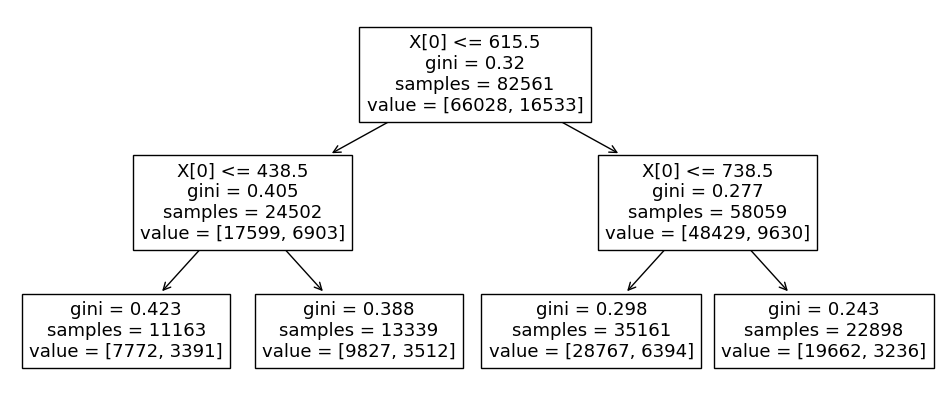

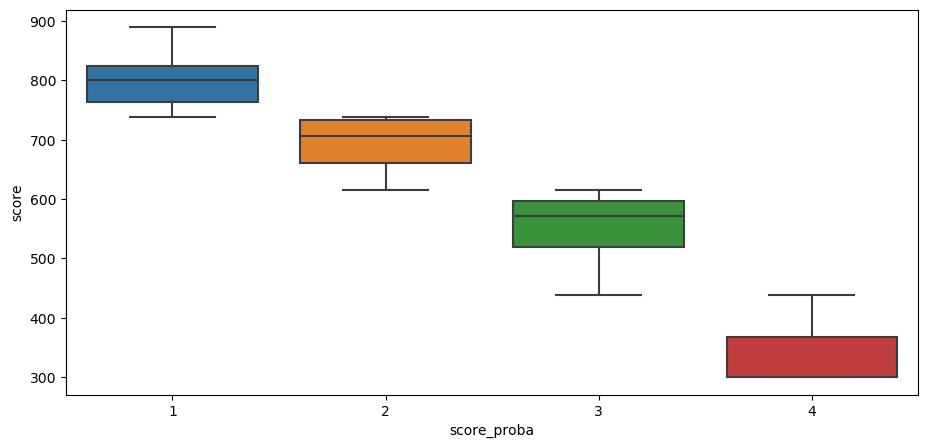

In [42]:
# o grande número de scores iguais a 0 tornam a variável score menos confiável, 
# para contornar este problema, podemos alocar este grupo de dados sob a categoria 0, antes de passar os
# dados no modelo

# como ficariam os dados de 'score', sem o grande volume de zeros ?
aux = df.copy()
aux = aux.loc[df['score'] > 20]
tree_box_plot(aux, 'score', 'default', [4, 3, 2], 42)

In [43]:
# notamos que com 8 ou mais bins, a variável continua inconsistente, mas com 4, ela passa a ser útil,
# após lidarmos com os zeros

# conclusão da análie de 'score' e 'score_desc' podemos utilizar 'score', alocando valores de 0-18 sob a 
# categoria 0 e posteriormente, criando 4 bins para os valores restantes (seria melhor se todas as variáveis
# possuíssem o mesmo número de bins ?)

In [44]:
# em seguida, análise de 'tem_med_emp' e 'tem_pri_emp'

# em que formato se encontram os dados ?

print(df['tem_med_emp'].unique()[0:5])
print(df['tem_pri_emp'].unique()[0:5])
# percebe-se que todos possuem inteiros, seguidos de 'yrs' e 'mon', (anos, meses)
# pretendo transformar os valores em meses apenas (1 ano = 12 meses)
df['tem_med_emp'] = df['tem_med_emp'].apply(lambda x: time_unit_unification(x))
df['tem_pri_emp'] = df['tem_pri_emp'].apply(lambda x: time_unit_unification(x))

['0yrs 8mon' '1yrs 1mon' '0yrs 5mon' '0yrs 10mon' '0yrs 0mon']
['5yrs 5mon' '1yrs 1mon' '1yrs 4mon' '3yrs 1mon' '0yrs 0mon']


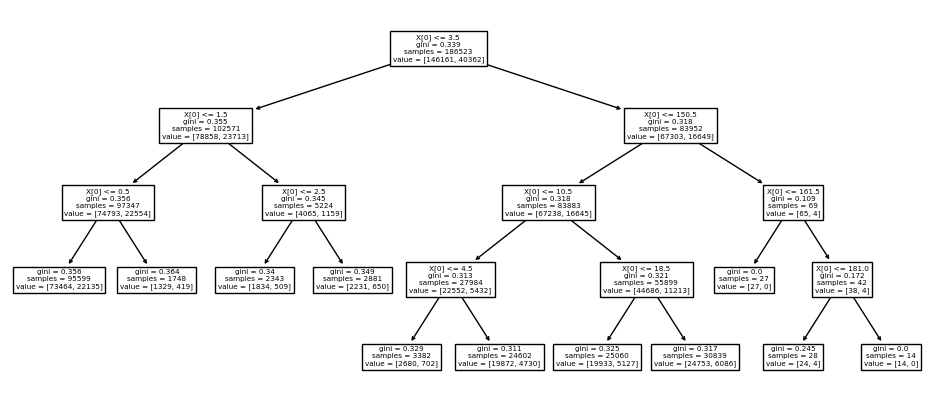

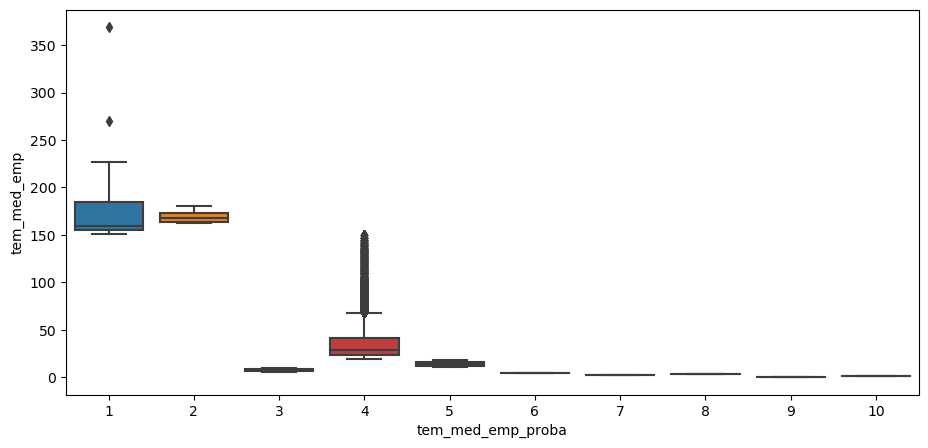

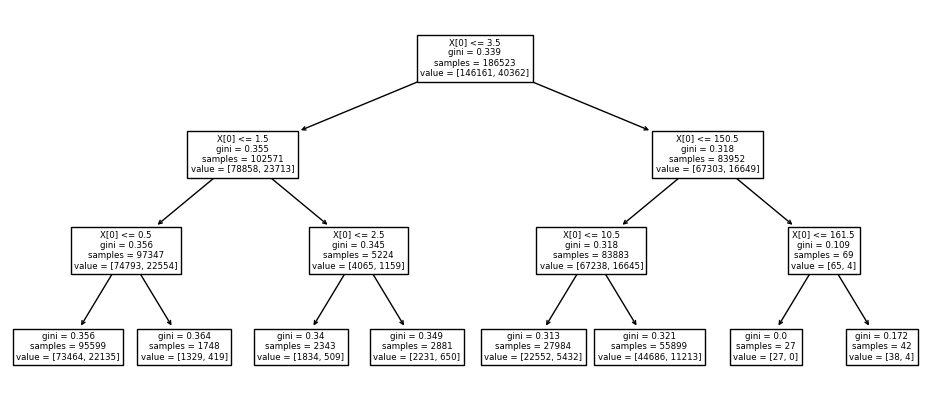

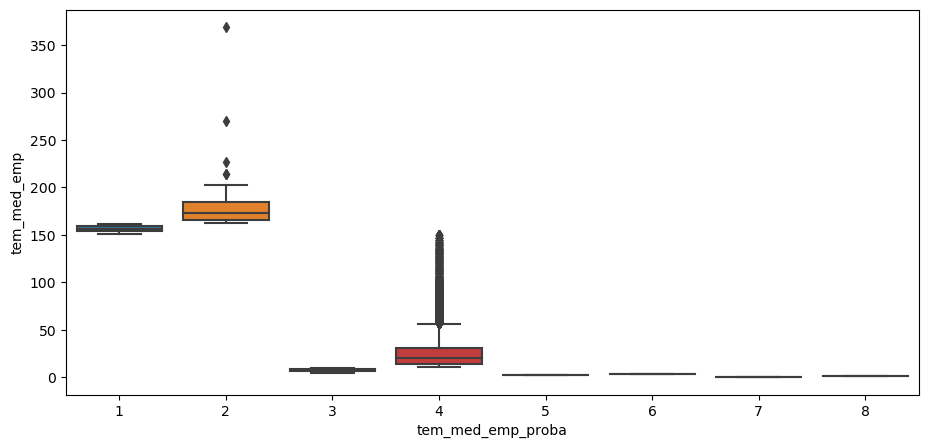

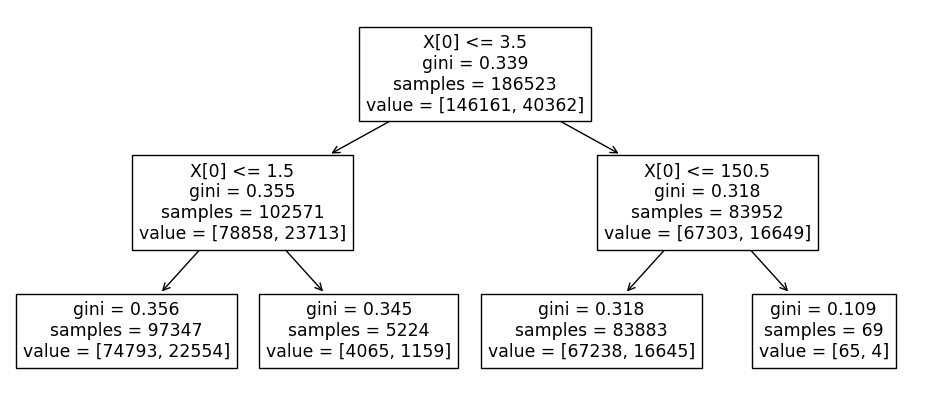

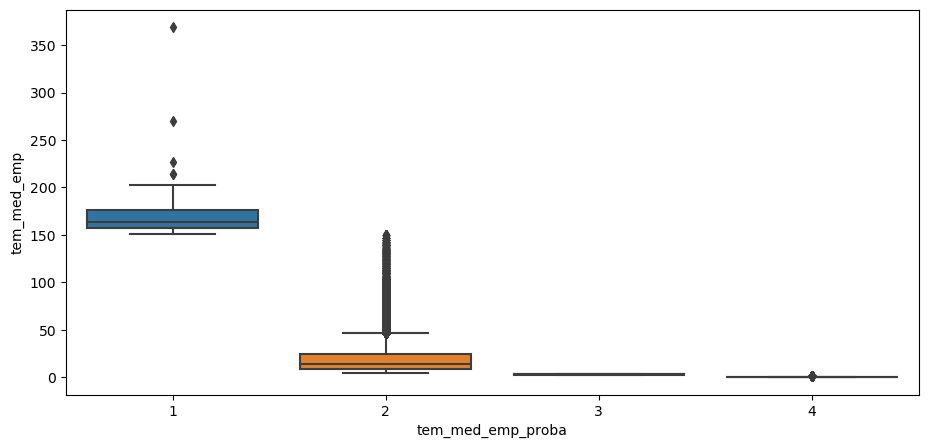

In [45]:
# tempo é uma grandeza contínua, sendo assim, lido com estas series da mesma forma que as variáveis contínuas
# já estudadas neste notebook

# proba_box(df, 'tem_med_emp', 'default', 3, 42)
# proba_box(df, 'tem_med_emp', 'default', 2, 42)
tree_box_plot(df, 'tem_med_emp', 'default', [4, 3, 2], 42)

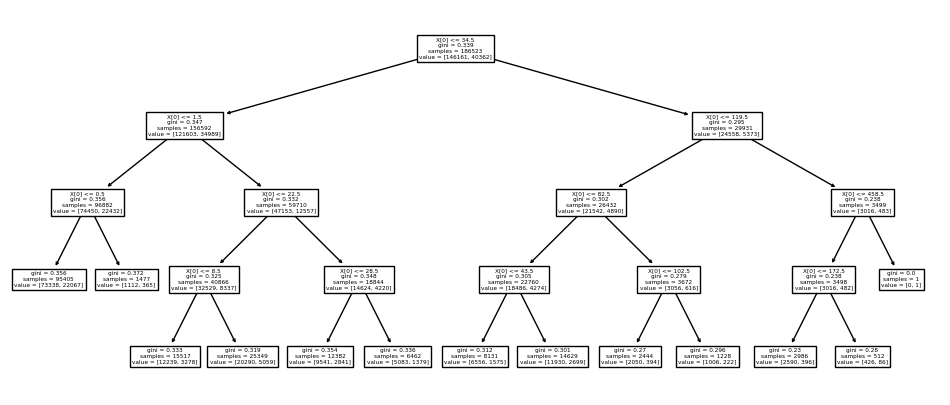

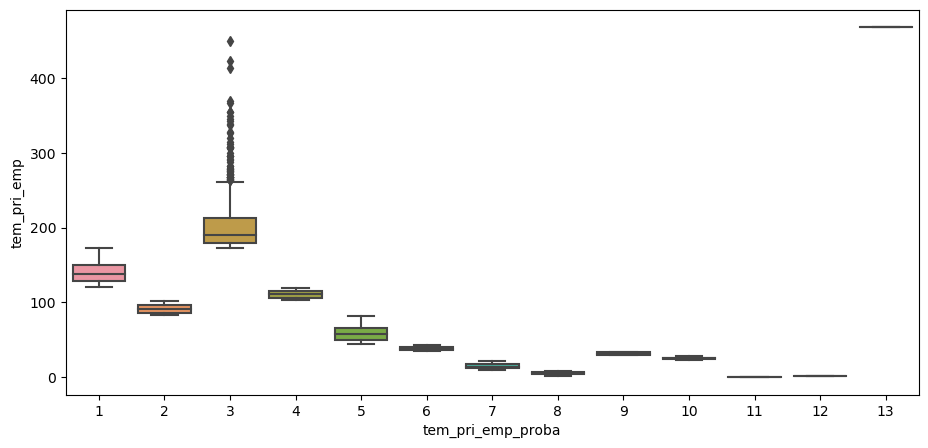

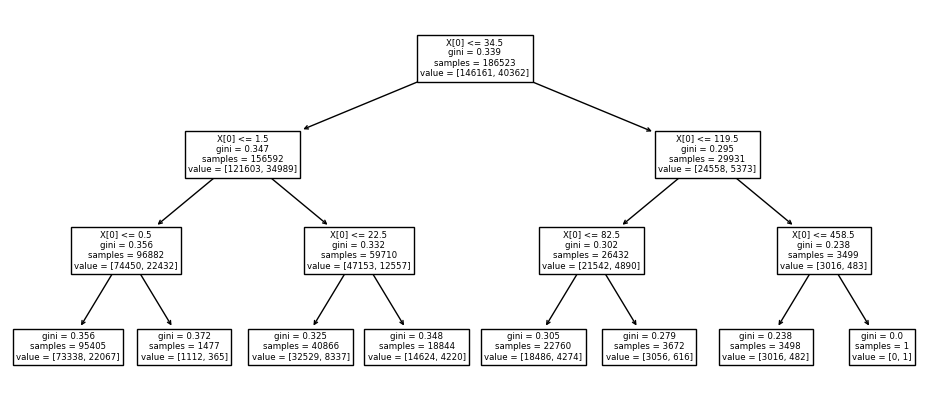

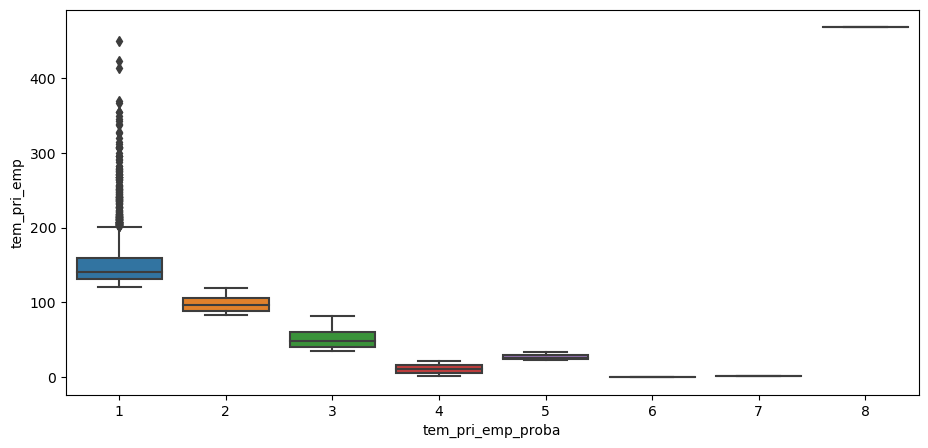

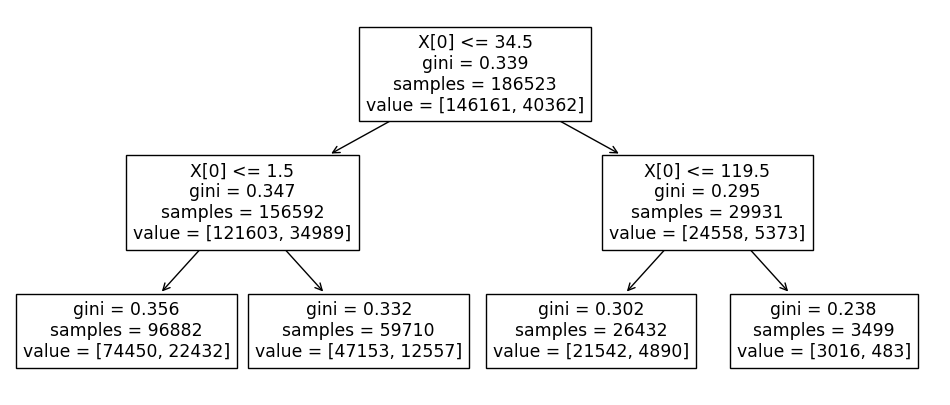

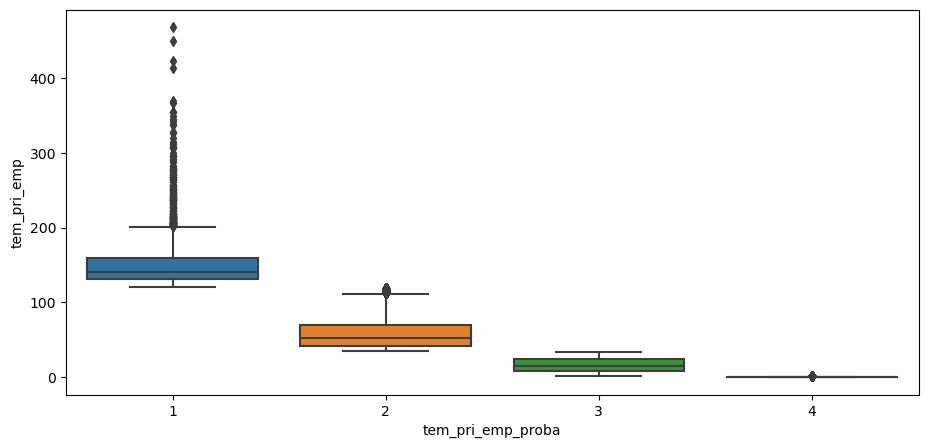

In [46]:
tree_box_plot(df, 'tem_pri_emp', 'default', [4, 3, 2], 42)

In [47]:
# conclusão da análise de  'tem_med_emp' e 'tem_pri_emp':
# para considerar o uso de 'tem_med_emp' e 'tem_pri_emp', em ambos os casos, seria necessário trabalhar com
# 4 bins, se formos comparar os plots das variáveis, percebe-se uma tendência mais definida em 'tem_pri_emp'

In [48]:
# em seguida, análise das variáveis referentes às contas primária e secundária: 'pri_qtd_tot_emp', 
# 'pri_qtd_tot_emp_atv', 'pri_qtd_tot_def', 'pri_emp_abt', 'pri_emp_san', 'pri_emp_tom', 'sec_qtd_tot_emp',
# 'sec_qtd_tot_emp_atv', 'sec_qtd_tot_def', 'sec_emp_abt', 'sec_emp_san','sec_emp_tom'

# chegamos à conclusão de que podemos somar os dados das contas primária e secundária de cada dado
df['qtd_tot_emp'] = df['pri_qtd_tot_emp'] + df['sec_qtd_tot_emp'] 
df['qtd_tot_emp_atv'] = df['pri_qtd_tot_emp_atv'] + df['sec_qtd_tot_emp_atv'] 
df['qtd_tot_def'] = df['pri_qtd_tot_def'] + df['sec_qtd_tot_def'] 
df['emp_abt'] = df['pri_emp_abt'] + df['sec_emp_abt'] 
df['emp_san'] = df['pri_emp_san'] + df['sec_emp_san']
df['emp_tom'] = df['pri_emp_tom'] + df['sec_emp_tom']

# elas ordenam o 'default' ? são todas quantitativas

qtd_tot_emp


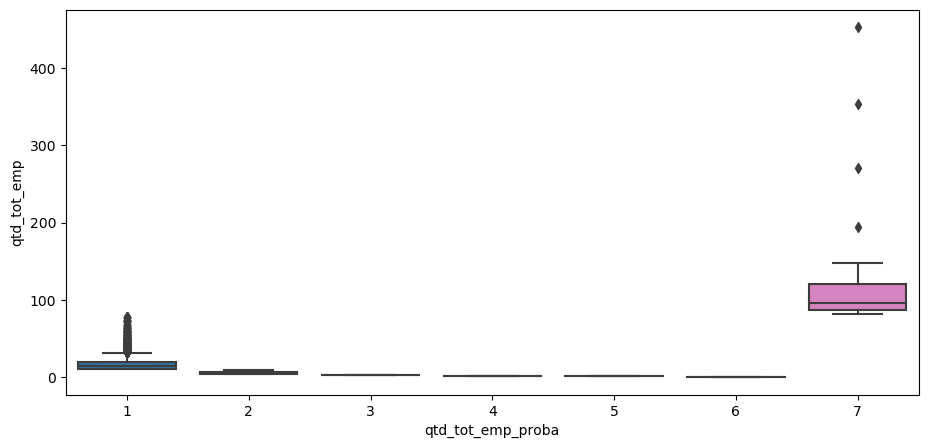

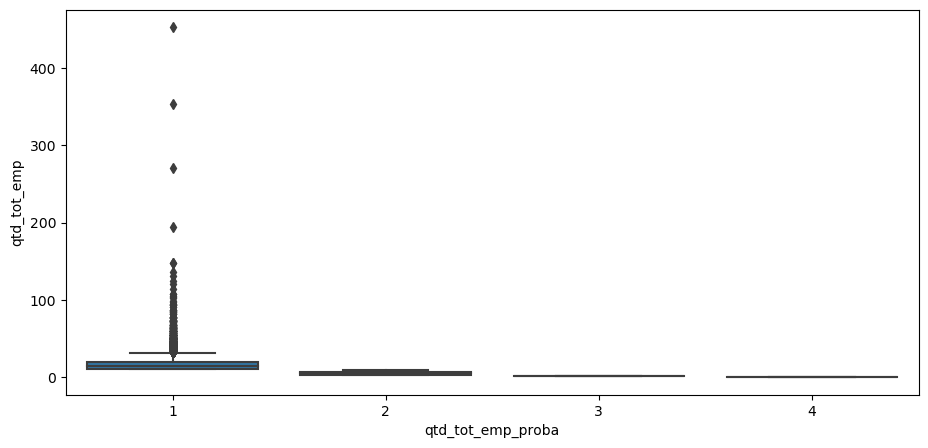

qtd_tot_emp_atv


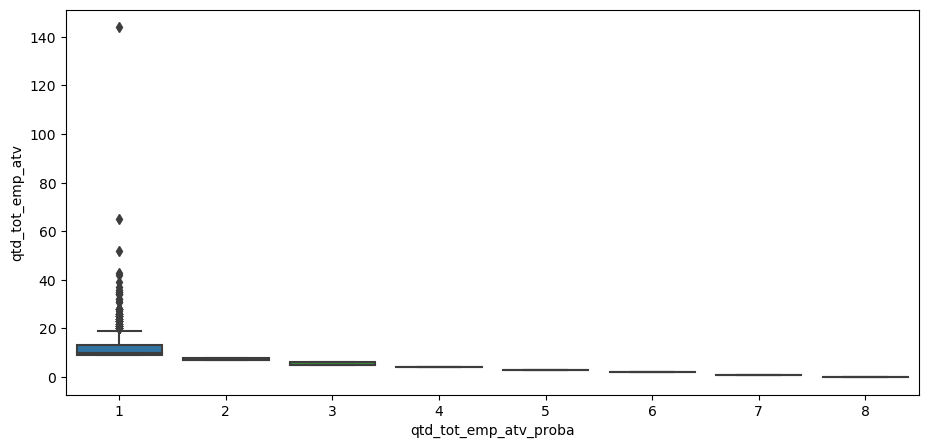

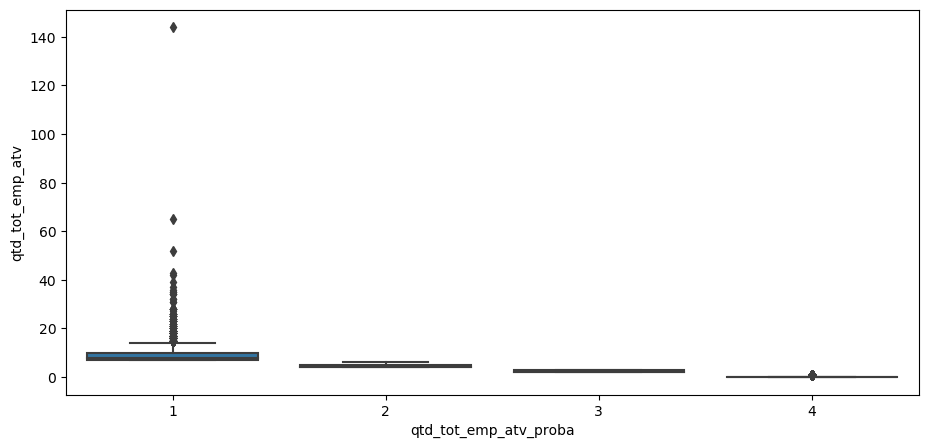

qtd_tot_def


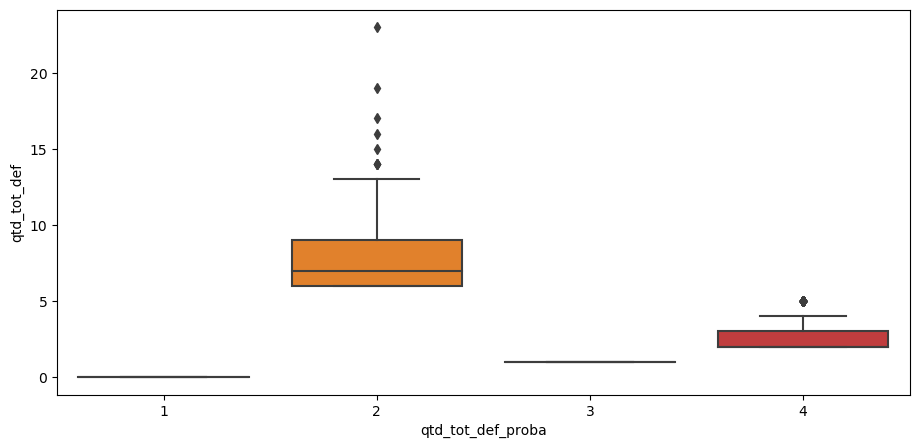

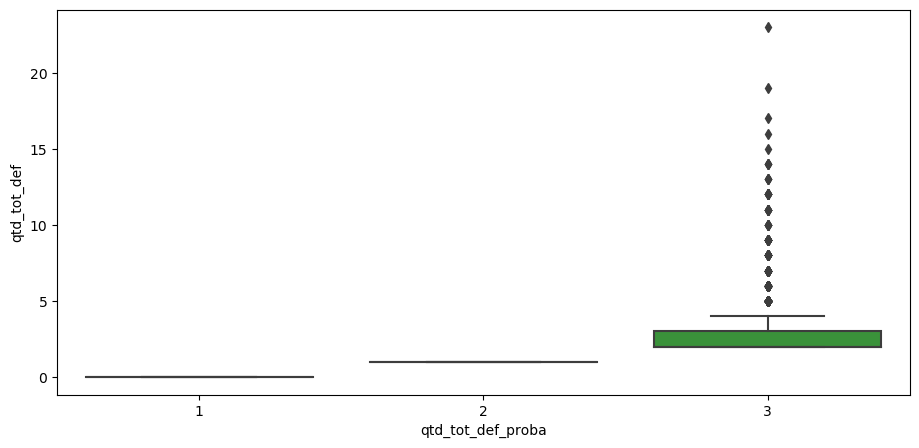

emp_abt


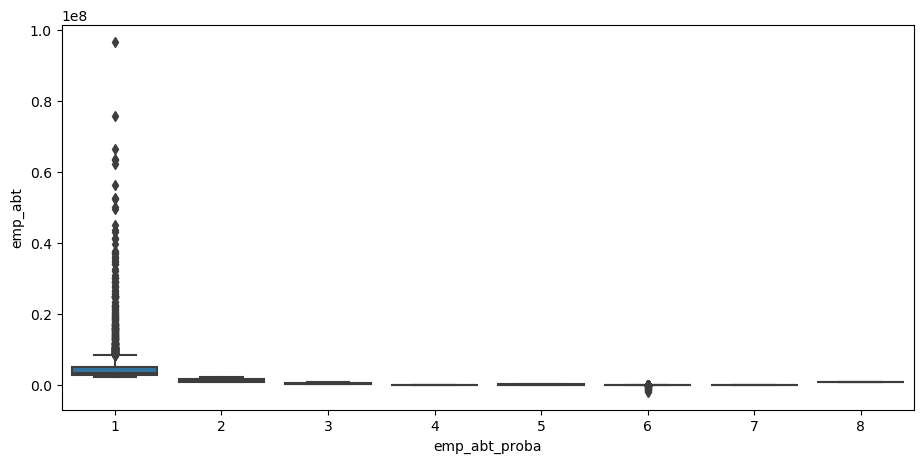

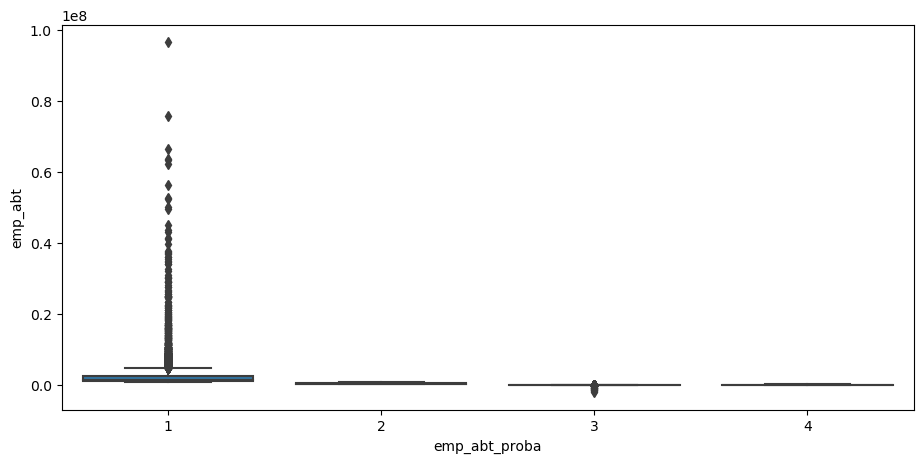

emp_san


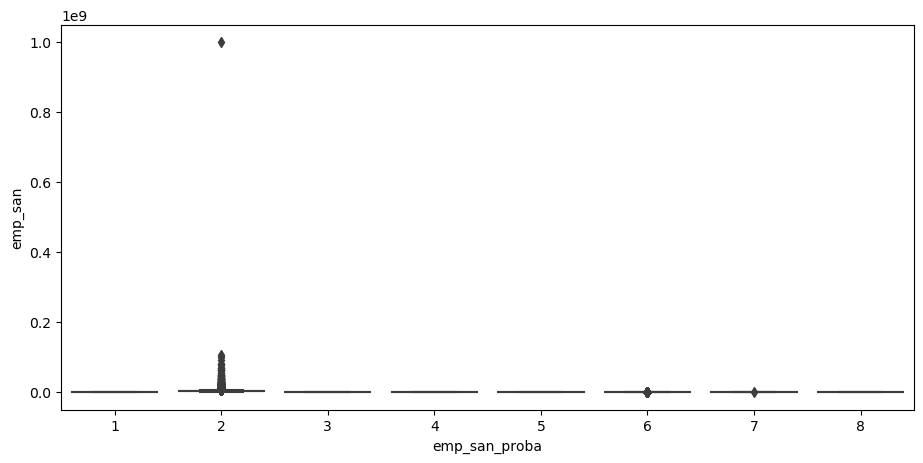

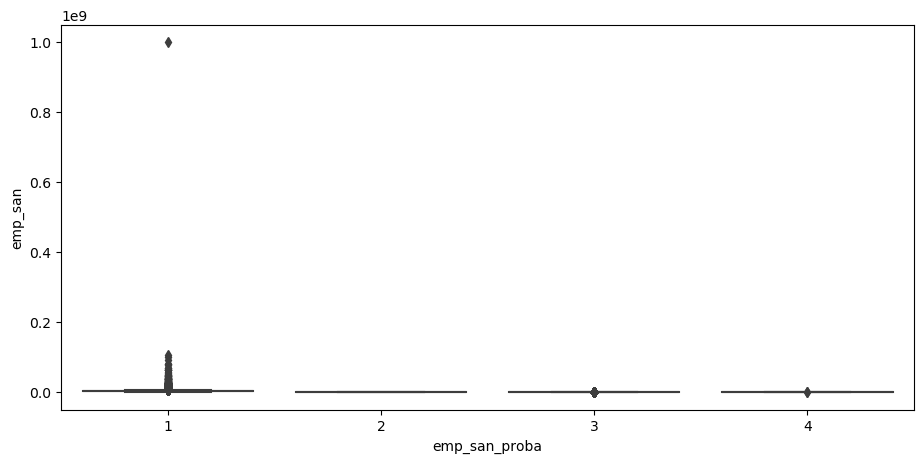

emp_tom


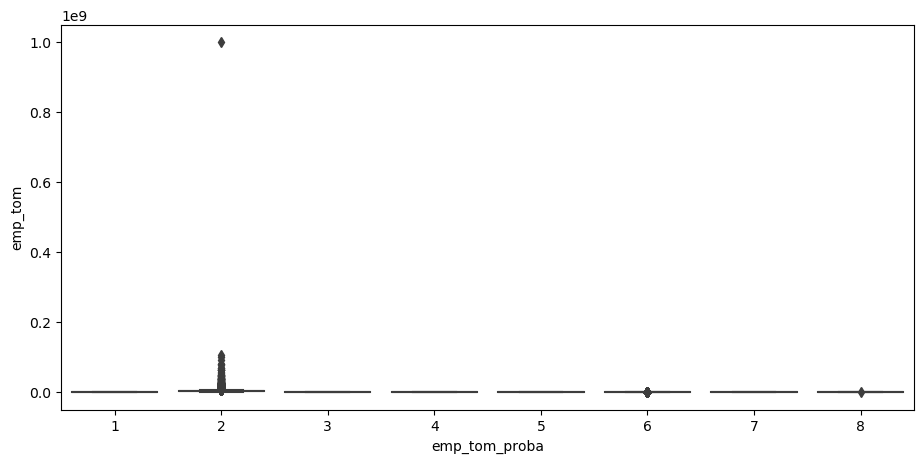

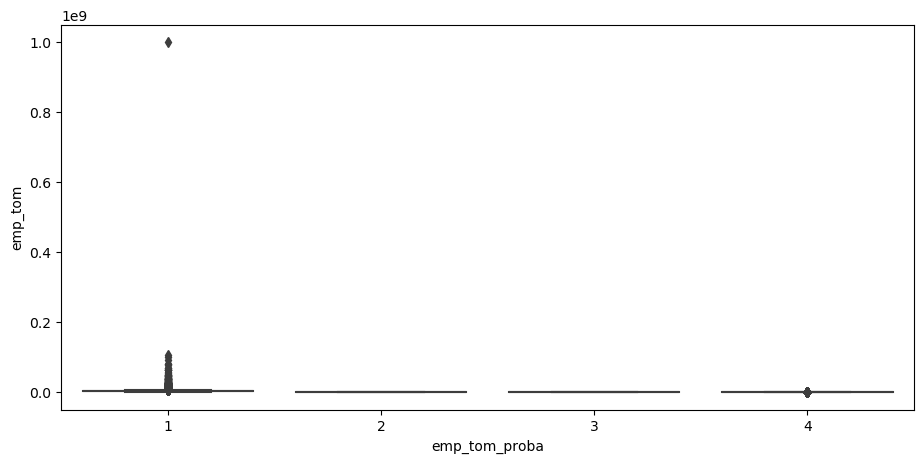

In [49]:
acc_vars = ['qtd_tot_emp' ,'qtd_tot_emp_atv' ,'qtd_tot_def' ,'emp_abt' ,'emp_san' ,'emp_tom']
for var in acc_vars:
    print(var)
    proba_box(df, var, 'default', 3, 42)
    proba_box(df, var, 'default', 2, 42)

In [50]:
# depois desta análise, acho que talvez tenha feito algo errado ou que esteja interpretando mal os dados
# o fato de os ranges que compõe cada categoria criada na discretização serem maiores ou menores quer dizer que
# é mais ou menos interessante usar a variável ? ou todas valem o mesmo, desde que exista ordem ?

# conclusão da análise das variáveis referentes às contas:
# todos os resultados são decepcionantes

In [51]:
# neste ponto do notebook, todas as features que nos propusemos a analisar foram analisadas

In [52]:
# as features que se mostraram mais interessantes foram 'emprestimo_custo_proba' , 'idade_proba',
# 'score_proba' ,'tem_pri_emp_proba', em 4 bins (score precisa ser tratada à parte)
df_x = df.copy()
df_x = df_x[['emprestimo_custo_proba', 'idade_proba', 'tem_pri_emp_proba', 'score', 'default']]
df_x.loc[df_x.index.isin(df_x.loc[df_x['score'] < 20].index), 'score'] = 0

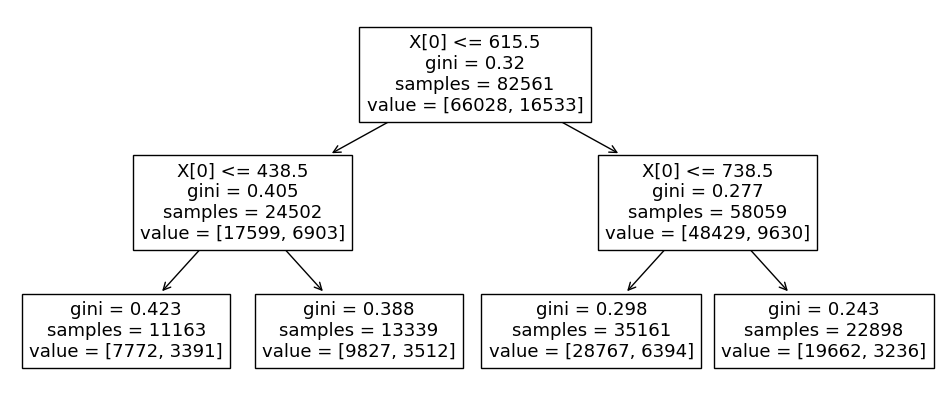

In [53]:
x = df_x.loc[df_x['score'] != 0][['score']]
y = df_x.loc[df_x['score'] != 0][['default']]
mdl = DecisionTreeClassifier(random_state = 42, max_depth = 2)
mdl.fit(x, y)
fig = plt.figure(figsize = (12, 5))
_ = tree.plot_tree(mdl)
plt.show()

In [54]:
def score_new_disc(x):
    if x <= 438.5:
        return 1
    elif x > 438.5 and x <= 615.5:
        return 2
    elif x > 615.5 and x <= 738.5:
        return 3
    elif x > 738.5:
        return 4
    
z_series = df_x.loc[df_x['score'] == 0]['score']
nonz_series = df_x.loc[df_x['score'] != 0]['score'].apply(lambda x: score_new_disc(x))

disctzd_score = pd.concat([z_series, nonz_series])
disctzd_score = disctzd_score.rename('a')
df_x = df_x.join(disctzd_score).drop(columns = ['score'])

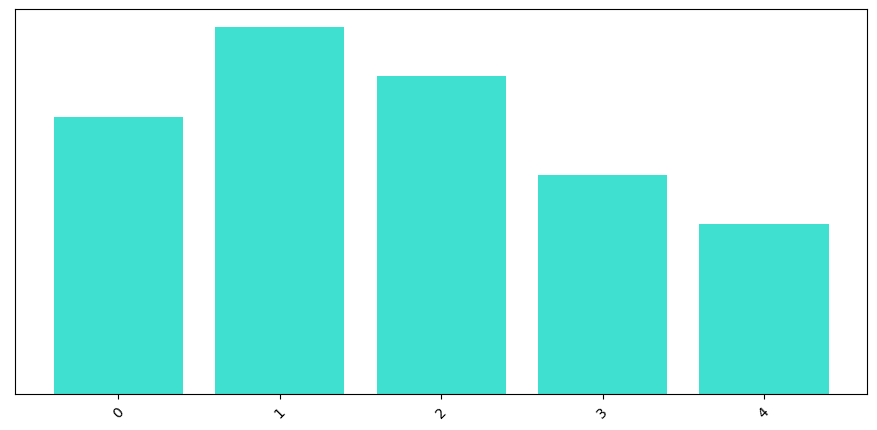

In [70]:
target_prop_bin(df_x, 'a', 'default')

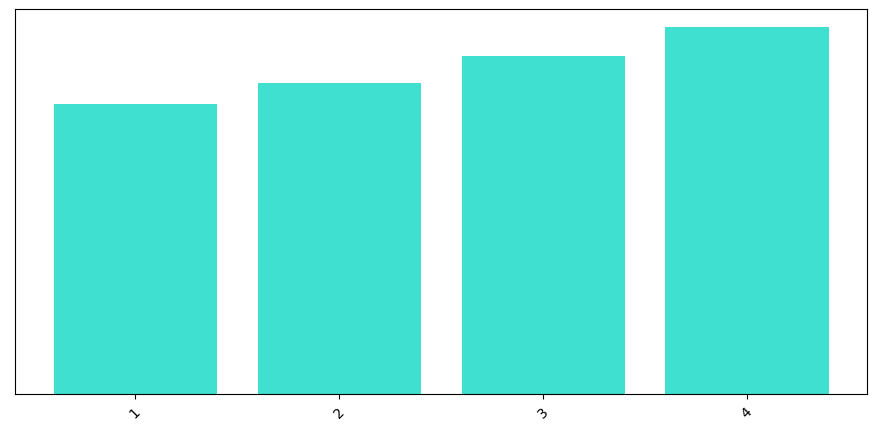

In [71]:
target_prop_bin(df_x, 'idade_proba', 'default')

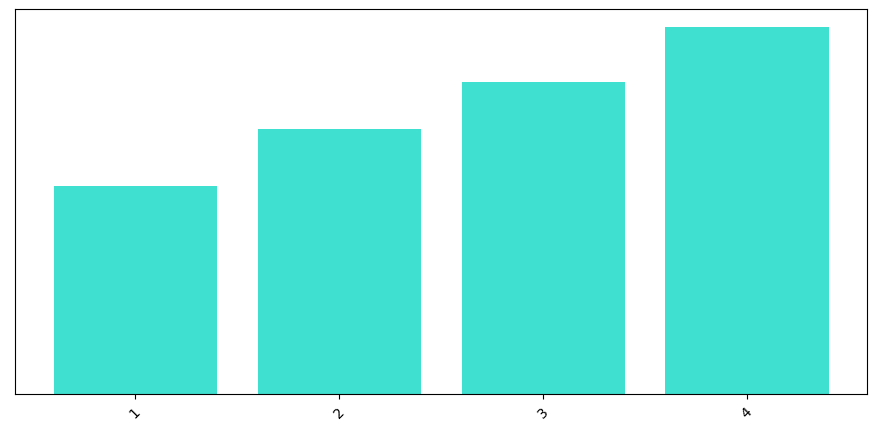

In [72]:
target_prop_bin(df_x, 'emprestimo_custo_proba', 'default')

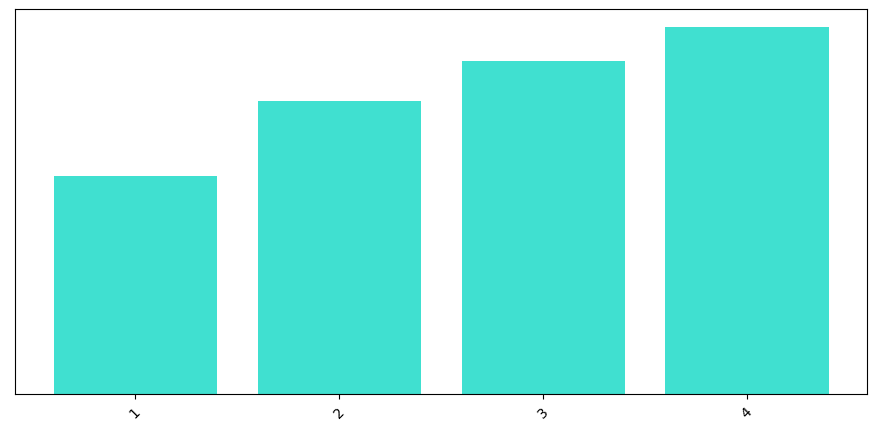

In [73]:
target_prop_bin(df_x, 'tem_pri_emp_proba', 'default')

In [ ]:
# x = df_x[['emprestimo_custo_proba', 'idade_proba', 'tem_pri_emp_proba', 'a']]
# y = df_x['default']

# lr = LogisticRegression()
# lr.fit(x, y)

# lista = [i[1] for i in lr.predict_proba(x)]
# roc_auc_score(y, lr.decision_function(x))
# roc_auc_score(y, lista)
# (2 * roc_auc_score(y, lista)) - 1